# 逻辑回归建模流程

## 1.读入数据
数据集使用的是[UCI Machine Learning](http://archive.ics.uci.edu/ml/index.php)资源,这是来自一个西班牙银行的营销数据（电话营销）。数据集的目标变量（y）是用来标记客户是否会对营销活动有响应(1/0)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
matplotlib.style.use('ggplot')

data = pd.read_csv('data/banking.csv')
data = data.dropna()
data['education']=np.where(np.in1d(data['education'],['basic.9y', 'basic.6y', 'basic.4y']), 'Basic', data['education'])

print(data.columns)
data.head()

/Applications/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,Basic,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,Basic,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


自变量解释
  1. age (numeric)
  2. job : type of job (categorical: “admin”, “blue-collar”, “entrepreneur”, “housemaid”, “management”, “retired”, “self-employed”, “services”, “student”, “technician”, “unemployed”, “unknown”)
  3. marital : marital status (categorical: “divorced”, “married”, “single”, “unknown”)
  4. education (categorical: “basic.4y”, “basic.6y”, “basic.9y”, “high.school”, “illiterate”, “professional.course”, “university.degree”, “unknown”)
  5. default: has credit in default? (categorical: “no”, “yes”, “unknown”)
  6. housing: has housing loan? (categorical: “no”, “yes”, “unknown”)
  7. loan: has personal loan? (categorical: “no”, “yes”, “unknown”)
  8. contact: contact communication type (categorical: “cellular”, “telephone”)
  9. month: last contact month of year (categorical: “jan”, “feb”, “mar”, …, “nov”, “dec”)
  10. day_of_week: last contact day of the week (categorical: “mon”, “tue”, “wed”, “thu”, “fri”)
  11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
  12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  14. previous: number of contacts performed before this campaign and for this client (numeric)
  15. poutcome: outcome of the previous marketing campaign (categorical: “failure”, “nonexistent”, “success”)
  16. emp.var.rate: employment variation rate — (numeric)
  17. cons.price.idx: consumer price index — (numeric)
  18. cons.conf.idx: consumer confidence index — (numeric)
  19. euribor3m: euribor 3 month rate — (numeric)
  20. nr.employed: number of employees — (numeric)

## 1.2 基础项配置
工作路径，目标变量名称等配置，方便后续的代码泛用

In [4]:
parentpath = './'
target = 'y'
catvars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
numvars = list(set(data.columns) - set(catvars + [target]))
print(numvars)
df = data
df.dtypes

['cons_conf_idx', 'pdays', 'previous', 'age', 'duration', 'nr_employed', 'euribor3m', 'cons_price_idx', 'emp_var_rate', 'campaign']


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

## 1.3 训练集测试集划分
简单的划分测试集与训练集。训练集与测试集的划分方式主要分为两种：
    1. 基于随机数的划分方式，这种情形一般主要是因为我们无法获取数据记录的时间；
    2. 基于时间的划分，一般来说针对风险模型，我们都主要采用这种方式。即以某一个时间点之前的数据作为训练集，时间点之后的数据作为验证集。
考虑到此处的数据仅是练习，只以随机的方式划分测试与训练集

In [3]:
import numpy as np
np.random.seed(12345678)
dataset_flag = np.where(np.random.uniform(0, 1, df.shape[0]) < 0.7, 'train', 'test')
dstrain = df[dataset_flag == 'train']
dstest = df[dataset_flag == 'test']
y_train = np.array(dstrain[target])
print(dstrain.shape)
print(dstest.shape)

(28823, 21)
(12365, 21)


## 2. 探索性数据分析
针对类别型变量与数值型变量对变量做初步探查

### 2.1 目标变量探查
查看目标数据的样本百分比

In [13]:
dstrain[target].value_counts()

0    25559
1     3264
Name: y, dtype: int64

## 2.2 基础函数定义
定义用于处理数值型变量与类别型变量的基本函数

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jan  6 15:22:09 2018

@author: long.li
"""
import numpy as np
from scipy import stats
import pandas as pd

def eda_num_base(arr, missset = [np.nan]):
    '''
    arr: numpy array as input
    output: dict with all statistics
    '''
    
    result = {}
    n = len(arr)
    result['n'] = n
    
    arr_nonmiss = arr[~(np.isnan(arr) | np.in1d(arr,missset))]
    n_nonmiss = len(arr_nonmiss)
    
    result['nmiss'] = result['n'] - n_nonmiss
    
    result['min'] = np.nan if n_nonmiss == 0 else min(arr_nonmiss)
    result['max'] = np.nan if n_nonmiss == 0 else max(arr_nonmiss)
    result['mean'] = np.nan if n_nonmiss == 0 else np.mean(arr_nonmiss)
    result['std'] = np.nan if n_nonmiss == 0 else np.std(arr_nonmiss, ddof = 1)
    # calculate mode
    result['mode'] = np.nan if n_nonmiss == 0 else stats.mode(arr_nonmiss)[0][0]
    
    quant_point = [1, 5, 25, 50, 75, 95, 99]
    quant_arr = [np.nan] * len(quant_point) if n_nonmiss == 0 else np.percentile(arr_nonmiss, quant_point, interpolation='lower')
    
    quant_dict = dict(zip(['q%02d' % i for i in quant_point], quant_arr))
    
    result = dict(result, **quant_dict)
    
    result['pct_mode'] = sum(arr_nonmiss == result['mode']) / n
    result['pct_q01'] = sum(arr_nonmiss <= quant_dict['q01']) / n
    result['pct_q99'] = sum(arr_nonmiss >= quant_dict['q99']) / n
    
    # floor & cap treatment
    arr_trim = np.clip(arr_nonmiss, quant_dict['q01'], quant_dict['q99'])
    result['trim_mean'] = np.nan if n_nonmiss == 0 else np.mean(arr_trim)
    result['trim_std'] = np.nan if n_nonmiss == 0 else np.std(arr_trim, ddof = 1)
    
    return result
    
def eda_num_df(df, missset = [np.nan]):
    
    num_dict = {k: np.array(df[k], dtype = np.float64) for k in df.columns}
    eda_num_dict = [dict(eda_num_base(v), varname = k) for k, v in num_dict.items()]

    return pd.DataFrame(eda_num_dict)

    
def eda_cat_df(df, target):
    return pd.concat([eda_cat_base(v, target).assign(varname = k) for k,v in df.items()])


def eda_cat_base(x, y):
    '''
    y is  0/1 or continous data
    '''
    return pd.DataFrame(dict(n = y, mean = y, std = y, value = x)).groupby(['value'], as_index = False).\
        agg({'n':len, 'mean':np.mean, 'std': lambda x: np.std(x, ddof = 1)})


## 2.3 数值型变量EDA
计算数值型变量基本统计量，包括：数量，缺失量，均值，标准差，最大值，最小值，众数，1、5、25、50、75、95、99分位点，trimed均值与标准差，众数占比，trim以后1，99分位数占比。

In [5]:
num_dict = {k: np.array(dstrain[k], dtype = np.float64) for k in numvars}
eda_num_dict = [dict(eda_num_base(v), varname = k) for k, v in num_dict.items()]
df_eda_num  = pd.DataFrame(eda_num_dict)
df_eda_num.to_csv(parentpath + 'result/stat_eda_num.csv', index = False, sep = '\t')
df_eda_num.head()

,max,mean,min,mode,n,nmiss,pct_mode,pct_q01,pct_q99,q01,q05,q25,q50,q75,q95,q99,std,trim_mean,trim_std,varname
0,4918.0,258.569129,0.0,90.0,28823,0,0.004545,0.010721,0.010061,11.0,36.0,103.0,180.0,320.0,747.0,1266.0,259.644048,254.548208,234.305774,duration
1,98.0,40.051174,17.0,31.0,28823,0,0.047046,0.014641,0.010339,23.0,26.0,32.0,38.0,47.0,58.0,71.0,10.441077,40.001214,10.147232,age
2,-26.9,-40.488062,-50.8,-36.4,28823,0,0.189952,0.010027,0.011172,-50.0,-47.1,-42.7,-41.8,-36.4,-33.6,-26.9,4.642449,-40.485425,4.636815,cons_conf_idx
3,6.0,0.172571,0.0,0.0,28823,0,0.863338,0.863338,0.025709,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.492383,0.162370,0.432932,previous
4,5228.1,5166.754616,4963.6,5228.1,28823,0,0.393366,0.015647,0.393366,4963.6,5008.7,5099.1,5191.0,5228.1,5228.1,5228.1,72.477860,5166.754616,72.477860,nr_employed


## 2.4 类别型变量EDA
统计每个变量不同类别下数量，目标均值，标准差等统计量

In [6]:

#fillna with missing/ data preparocess
df_cat = dstrain[catvars].fillna('missing')
cat_dict = {k: np.array(df_cat[k]) for k in catvars}
eda_num_list = [eda_cat_base(v, y_train).assign(varname = k) for k,v in cat_dict.items()]

df_eda_cat = pd.concat(eda_num_list)
df_eda_cat.to_csv(parentpath + 'result/stat_eda_cat.csv', index = False, sep = '\t')
df_eda_cat.head()

,value,n,mean,std,varname
0,fri,5402,0.109774,0.312637,day_of_week
1,mon,5891,0.095400,0.293791,day_of_week
2,thu,6092,0.121471,0.326700,day_of_week
3,tue,5686,0.119416,0.324306,day_of_week
4,wed,5752,0.119958,0.324941,day_of_week


# 3. 数据预处理
分别针对数值型变量与类别性变量做相应处理

## 3.1 定义基础函数
针对数值型变量与类别型变量代码生成的函数

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Jan  8 11:19:04 2018

@author: long.li
"""

import pandas as pd
import numpy as np
import itertools

def dataproc_genfunc_num(df, dsname = 'dfinput', outdir = './'):
    functempl = '''
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np

def dataproc_func_num(%(dsname)s):
%(indent)s%(missflag)s
%(indent)s%(floorandcap)s
%(indent)s%(otherflag)s
%(indent)sreturn %(dsname)s
    '''
    formatdict = {}
    formatdict['indent'] = '    '
    formatdict['dsname'] = dsname
    formatdict['missflag'] = '\n%(indent)s'.join(df[df['dealtype'] == 'missflag']['code']) %formatdict
    formatdict['floorandcap'] = '\n%(indent)s'.join(df[df['dealtype'] == 'missfc']['code']) %formatdict
    formatdict['otherflag'] = '\n%(indent)s'.join(df[~df['dealtype'].isin(['missflag', 'missfc'])]['code']) %formatdict
    
    with open(outdir + 'result/func_preproc_num.py', 'w+') as f:
        f.write(functempl % formatdict)
    return functempl % formatdict
    
    

def dataproc_gencode_num(df, missset = [np.nan], dsname = 'dfinput', lang = 'python', missTagMethod = 'all',missImpMethod = 'mean', tagPct = 0.05):
    '''
    return generated code by giving certain codes
    
    Args:
            df: input dataframe by eda result
            missset: missing value set
            lang: which language to generate, other language will be added like R
            missTagMethod: how to add missing value flag, all types of missing value add one flag or add a flag for each
            missImpMethod: how to imputate missing value，with mean, median or 0
            tagPct: the threshold to set deciding whether add a flag or not
    returns:
            a dataframe with varname, originname, treatement type, treatment code and desc
    '''
    genFunc = dataproc_gencode_num_python
    
    allResult = [genFunc(item, missset, dsname, missTagMethod, missImpMethod, tagPct) 
        for item in df.to_dict(orient='records')]
    return pd.DataFrame(list(itertools.chain(*allResult)))
    

def dataproc_gencode_num_python(var_stat, missset = [np.nan], dsname = 'dfinput', missTagMethod = 'all',missImpMethod = 'mean', tagPct = 0.05):
    '''
    var_stat: eda for each variable
    '''
    missSetList = '[%s]' %(','.join([str(i) if not np.isnan(i) else 'np.nan' for i in missset]))
    varinfo = dict(var_stat, dsname = dsname, misslist = missSetList, missimpute = var_stat.get(missImpMethod, 0))
    
    result = []
    # missing value flag
    if missTagMethod == 'all':
         result = result + [{'varname': 'FM1_%s' %varinfo['varname']
                ,'orginname': varinfo['varname']
                ,'dealtype': 'missflag'
                ,'code': '%(dsname)s["FM1_%(varname)s"] = (np.in1d(%(dsname)s["%(varname)s"], %(misslist)s) | (np.isnan(%(dsname)s["%(varname)s"]))) + 0' %varinfo
                ,'desc': 'missing value flag: %(misslist)s for %(varname)s' %varinfo}]
    # missing imputate & floor cap
    missimput = '%(dsname)s["%(varname)s"][np.in1d(%(dsname)s["%(varname)s"], %(misslist)s) | (np.isnan(%(dsname)s["%(varname)s"]))] = %(missimpute)s' %varinfo
    floorcap = '%(dsname)s["%(varname)s"] = np.clip(%(dsname)s["%(varname)s"], %(q01)f, %(q99)f)' %varinfo
    result = result + [{'varname': varinfo['varname']
            ,'orginname': varinfo['varname']
            ,'dealtype': 'missfc'
            ,'code': missimput + ';' + floorcap
            ,'desc': 'origin vairable after missing imputation and floor & cap %(varname)s' %varinfo}]
    # mode tag 
    if varinfo['pct_mode'] >= tagPct:
        result = result + [{'varname': 'FSM_%s' %varinfo['varname']
            ,'orginname': varinfo['varname']
            ,'dealtype': 'modeflag'
            ,'code': '%(dsname)s["FSM_%(varname)s"] = (%(dsname)s["%(varname)s"] == %(mode)f) + 0' %varinfo
            ,'desc': 'flag of mode for %(varname)s if percent is large than %(mode)f' %varinfo}]
    # 1%quantile flag lower bound
    if varinfo['pct_q01'] >= tagPct:
        result = result + [{'varname': 'FSL_%s' %varinfo['varname']
            ,'orginname': varinfo['varname']
            ,'dealtype': 'q01flag'
            ,'code': '%(dsname)s["FSL_%(varname)s"] = (%(dsname)s["%(varname)s"] == %(q01)f) + 0' %varinfo
            ,'desc': 'flag of lower bound for %(varname)s if percent is large than %(q01)f' %varinfo}]
    # 99%quantile flag upper bound
    if varinfo['pct_q99'] >= tagPct:
        result = result + [{'varname': 'FSU_%s' %varinfo['varname']
            ,'orginname': varinfo['varname']
            ,'dealtype': 'q99flag'
            ,'code': '%(dsname)s["FSU_%(varname)s"] = (%(dsname)s["%(varname)s"] == %(q99)f) + 0' %varinfo
            ,'desc': 'flag of upper bound for %(varname)s if percent is large than %(q99)f' %varinfo}]
    
    return result

def dataproc_genfunc_cat(df, dsname = 'dfinput', outname = 'result', outdir = './'):
    functempl = '''
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np

def dataproc_func_cat(%(dsname)s):
%(indent)s%(outname)s = {}
%(indent)s%(flag)s
%(indent)sreturn %(outname)s
'''
    formatdict = {}
    formatdict['indent'] = '    '
    formatdict['dsname'] = dsname
    formatdict['outname'] = outname
    formatdict['flag'] = '\n%(indent)s'.join(df['code']) %formatdict
    
    with open(outdir + 'result/func_preproc_cat.py', 'w+') as f:
        f.write(functempl % formatdict)
    return functempl % formatdict

def dataproc_gencode_cat_tag(df, outdir = './', method = 'onehot'):
    result = df.copy().reset_index()
    result['rank'] = result.groupby(['varname'])['n'].rank(method = 'first', ascending = False)
    result['prefix'] = ['FX%02d' %i for i in result['rank']]
    
    result.to_csv(outdir + 'result/code_preproc_cat_tag.csv', sep = '\t')
    return result

def dataproc_gencode_cat_python(df, dsname = 'dfinput', outname = 'result'):
    '''
    df: eda for category variable with flag added
    '''
    dfGrouoped = df.groupby(['varname', 'prefix'])['value'].apply(list).reset_index()
    
    f = lambda x: '%s["%s_%s"] = (%s) + 0' %(outname, x['prefix'], x['varname']\
            ,('%%s == %s' %(str(x['value'][0]) if type(x['value'][0]) != type('str') else '"%s"' %x['value'][0])  if len(x['value']) == 1 else 'np.in1d(%%s, %s)' % str(x['value']))
            % '%s["%s"]' %(dsname, x['varname']))
    dfGrouoped['code'] = dfGrouoped.apply(f, axis=1)
    dfGrouoped['orginname'] = dfGrouoped['varname']
    dfGrouoped['varname'] = dfGrouoped.apply(lambda x: "%s_%s" %(x['prefix'], x['orginname']), axis=1)
    dfGrouoped['desc'] = dfGrouoped.apply(lambda x: "flag of %s for %s" %(str(x['value']), x['orginname']), axis=1)
    
    return dfGrouoped


## 3.2 数值型变量数据预处理
针对数值型变量，做以下三个部分的数据预处理:
    1. 缺失值标记；
    2. 缺失值填充以及floor & cap处理
    3. 众数标记以及1和99分位点数据标记

In [106]:
# load eda result
# df_eda_num = pd.read_csv(parentpath + 'result/stat_eda_num.csv', sep = '\t')

# generate preprocess code for numeric variable
allResult = [dataproc_gencode_num_python(item) for item in df_eda_num.to_dict(orient='records')]
df_preproc_num_code = pd.DataFrame(list(itertools.chain(*allResult)))

df_preproc_num_code.to_csv(parentpath + 'result/code_preproc_num.csv', index = False, sep = '\t')

# generated function will be wroten in result folder
func_preproc_num = dataproc_genfunc_num(df_preproc_num_code, dsname = 'dfinput', outdir = './')

# data preprocess with generated code
import result.func_preproc_num as fppcn
# preprocess for numeric variable
# num_dict = {k: np.array(df[k], dtype = np.float64) for k in numvars}
df_ppc_num = fppcn.dataproc_func_num(num_dict)
df_preproc_num_code.head()

,code,dealtype,desc,orginname,varname
0,"dfinput[""FM1_emp_var_rate""] = (np.in1d(dfinput...",missflag,missing value flag: [np.nan] for emp_var_rate,emp_var_rate,FM1_emp_var_rate
1,"dfinput[""emp_var_rate""][np.in1d(dfinput[""emp_v...",missfc,origin vairable after missing imputation and f...,emp_var_rate,emp_var_rate
2,"dfinput[""FSM_emp_var_rate""] = (dfinput[""emp_va...",modeflag,flag of mode for emp_var_rate if percent is la...,emp_var_rate,FSM_emp_var_rate
3,"dfinput[""FSU_emp_var_rate""] = (dfinput[""emp_va...",q99flag,flag of upper bound for emp_var_rate if percen...,emp_var_rate,FSU_emp_var_rate
4,"dfinput[""FM1_pdays""] = (np.in1d(dfinput[""pdays...",missflag,missing value flag: [np.nan] for pdays,pdays,FM1_pdays


## 3.3 类别型变量数据预处理
现在主要以one hot方式增加哑变量

In [104]:
# 加载数据预处理的代码
# df_eda_cat = pd.read_csv(parentpath + 'result/stat_eda_cat.csv', sep = '\t')
# 生成类别型变量的数据预处理代码
df_ppc_cat_tag = dataproc_gencode_cat_tag(df_eda_cat)
df_ppc_cat_code = dataproc_gencode_cat_python(df_ppc_cat_tag)

df_ppc_cat_code.to_csv(parentpath + 'result/code_preproc_cat.csv', index = False, sep = '\t')
print(df_ppc_cat_code.head())
# generated function(categoric) will be wroten in result folder
func_preproc_cat = dataproc_genfunc_cat(df_ppc_cat_code)

# data preprocess with generated code
import result.func_preproc_cat as fppcc
# reload module & package
# import imp
# imp.reload(fppcc)

# cat_dict = {k: np.array(df[k]) for k in catvars}
df_ppc_cat = fppcc.dataproc_func_cat(cat_dict)


            varname prefix        value  \
0      FX01_contact   FX01   [cellular]   
1      FX02_contact   FX02  [telephone]   
2  FX01_day_of_week   FX01        [thu]   
3  FX02_day_of_week   FX02        [mon]   
4  FX03_day_of_week   FX03        [wed]   

                                                code    orginname  \
0  result["FX01_contact"] = (dfinput["contact"] =...      contact   
1  result["FX02_contact"] = (dfinput["contact"] =...      contact   
2  result["FX01_day_of_week"] = (dfinput["day_of_...  day_of_week   
3  result["FX02_day_of_week"] = (dfinput["day_of_...  day_of_week   
4  result["FX03_day_of_week"] = (dfinput["day_of_...  day_of_week   

                                desc  
0   flag of ['cellular'] for contact  
1  flag of ['telephone'] for contact  
2    flag of ['thu'] for day_of_week  
3    flag of ['mon'] for day_of_week  
4    flag of ['wed'] for day_of_week  


## 3.4 merge all variables

In [81]:
df_ppc_all = pd.DataFrame({**df_ppc_num,  **df_ppc_cat, **cat_dict})
df_ppc_all.to_csv(parentpath + 'data/preproc_all.csv', sep = '\t', index = False)
print(df_ppc_all.columns)
df_ppc_all.head()

Index(['FM1_age', 'FM1_campaign', 'FM1_cons_conf_idx', 'FM1_cons_price_idx',
       'FM1_duration', 'FM1_emp_var_rate', 'FM1_euribor3m', 'FM1_nr_employed',
       'FM1_pdays', 'FM1_previous', 'FSL_campaign', 'FSL_previous',
       'FSM_campaign', 'FSM_cons_conf_idx', 'FSM_cons_price_idx',
       'FSM_emp_var_rate', 'FSM_euribor3m', 'FSM_nr_employed', 'FSM_pdays',
       'FSM_previous', 'FSU_cons_price_idx', 'FSU_emp_var_rate',
       'FSU_nr_employed', 'FSU_pdays', 'FX01_contact', 'FX01_day_of_week',
       'FX01_default', 'FX01_education', 'FX01_housing', 'FX01_job',
       'FX01_loan', 'FX01_marital', 'FX01_month', 'FX01_poutcome',
       'FX02_contact', 'FX02_day_of_week', 'FX02_default', 'FX02_education',
       'FX02_housing', 'FX02_job', 'FX02_loan', 'FX02_marital', 'FX02_month',
       'FX02_poutcome', 'FX03_day_of_week', 'FX03_default', 'FX03_education',
       'FX03_housing', 'FX03_job', 'FX03_loan', 'FX03_marital', 'FX03_month',
       'FX03_poutcome', 'FX04_day_of_week', 'FX

,FM1_age,FM1_campaign,FM1_cons_conf_idx,FM1_cons_price_idx,FM1_duration,FM1_emp_var_rate,FM1_euribor3m,FM1_nr_employed,FM1_pdays,FM1_previous,...,euribor3m,housing,job,loan,marital,month,nr_employed,pdays,poutcome,previous
0,0,0,0,0,0,0,0,0,0,0,...,4.963,yes,blue-collar,no,married,aug,5228.1,999.0,nonexistent,0.0
1,0,0,0,0,0,0,0,0,0,0,...,4.021,no,technician,no,married,nov,5195.8,999.0,nonexistent,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.729,yes,management,no,single,jun,4991.6,6.0,success,2.0
3,0,0,0,0,0,0,0,0,0,0,...,1.405,no,services,no,married,apr,5099.1,999.0,nonexistent,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.869,yes,retired,no,married,aug,5076.2,3.0,success,1.0


# 4. 变量选择
使用多个方法选择变量，含单变量的选择方法以及模型的选择方法：
    1. 单变量选择方法: P值， IV值等；
    2. 模型选择方法：gbm，随机森林等；

## 4.1 IV值的选择方法
IV[information value](http://ucanalytics.com/blogs/information-value-and-weight-of-evidencebanking-case/)值反映的是两个不同群体间的概率密度分布的差异，本质上是[JSD](https://en.wikipedia.org/wiki/Jensen–Shannon_divergence)。通常的做法是，我们在不同的人群上使用相同的分组的方法，比如针对一个变量，其值域是1-100，我们按等分的办法没隔10分一组，即1-10，11-20...91-100，分成10组。我可以计算某一人群在其中一组占该人群的总体的百分比。如好人总共有1000人，其中在1-10这个区间好人有300个人，那么我们可以计算出来该组分布占比为0.3，依次可以计算出来坏人在该组的分布占比，以及对应的好人坏人在其他组的分布占比。
我们记好人在第i组的占比为P<sub>i</sub><sup>G</sup>，我们可以计算出第i组的[WOE](http://documentation.statsoft.com/STATISTICAHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview)为log(P<sub>i</sub><sup>B</sup>/P<sub>i</sub><sup>G</sup>)，在此基础上我们可以求得对应的IV值为
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
\\(IV = \sum_{i=0}^{n}(p_i^B - p_i^G)*log\frac{p_i^B}{p_i^G}\\)

使用IV值筛选变量的好处为能够发现自变量与应变量之间的非线性关系

### 4.1.1 定义切分函数
由于Python中没有现成的计算IV值的函数，所以需要我们自己定义对应的函数。我们在对目标函数分组的时候，如果使用等分的方式，那么得到的分组不一定是最好的状态，现在常用的分组方法为使用决策树的方法，这样得到的分组最能反映变量与目标之间的相关性。

In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree
from sklearn import tree
class vartrans_woe_num(object):
    
    def __init__(self, criterion = None, target_type = 'b', max_depth = 4, min_samples_leaf = 0.05):
        param = dict(max_depth = max_depth, min_samples_leaf = min_samples_leaf)
        if criterion is not None:
            param['criterion'] = criterion
        
        self.param = param
        self.target_type = target_type
        
    def fit(self, X, y, varname = 'x'):
        self.varname = varname
        
        clf = tree.DecisionTreeClassifier(**self.param) if self.target_type == 'b' else tree.DecisionTreeRegressor(**self.param)
        clf.fit(np.reshape(X, [-1,1]), y)
        
        cutPoint = np.unique(clf.tree_.threshold[clf.tree_.feature != _tree.TREE_UNDEFINED])
        
        group = pd.cut(X, [-np.inf] + list(cutPoint) + [np.inf] ,labels=False)
        n_neg = sum(1-y)
        n_pos = sum(y)
        dfBinning = pd.DataFrame({'group':group, 'n_pos':y, 'n_neg':1-y}).groupby(['group']).sum().reset_index()
        dfBinning['lower'] = np.append(-np.inf, cutPoint)
        dfBinning['upper'] = np.append(cutPoint, np.inf)
        dfBinning['pct_group_pos'] = dfBinning['n_pos']/n_pos
        dfBinning['pct_group_neg'] = dfBinning['n_neg']/n_neg
        dfBinning['woe'] = np.log(dfBinning['pct_group_pos']/dfBinning['pct_group_neg'])
        dfBinning['iv'] = dfBinning['woe']*(dfBinning['pct_group_pos']-dfBinning['pct_group_neg'])
        dfBinning['group_interval'] = dfBinning.apply(lambda x: "(%f, %f]" %(x['lower'], x['upper']), axis = 1)
        dfBinning['varname'] = varname
        return dfBinning, cutPoint
    
    def gen_code(self, lang = 'python', outdir = './'):
        pass
    

### 4.1.2 数值型变量离散分组

In [5]:
splitter = vartrans_woe_num()
num_dict = {k: np.array(dstrain[k], dtype = np.float64) for k in numvars}
vartrans_woe_dict = {k: splitter.fit(v, y_train, k) for k, v in num_dict.items()}
vartrans_woe_cut = {k:v[1] for k, v in vartrans_woe_dict.items()}
vartrans_woe_num_table = pd.concat([v[0] for k, v in vartrans_woe_dict.items()])
vartrans_woe_num_table.to_csv(parentpath + 'result/vartrans_woe_num_table.csv', index = False, sep = '\t')

# 将切个点导出到外部文件
import json_tricks
with open(parentpath + 'result/vartrans_woe_num_cut.json','w') as f:
    f.write(json_tricks.dumps(vartrans_woe_cut, primitives=True))

### 4.1.3 计算类别型变量的WOE值

In [77]:
df_eda_cat = pd.read_csv(parentpath + 'result/stat_eda_cat.csv', sep = '\t')

vartrans_woe_cat_table = df_eda_cat.copy()
vartrans_woe_cat_table['n_pos'] = vartrans_woe_cat_table['n'] * (1 - vartrans_woe_cat_table['mean'])
vartrans_woe_cat_table['n_neg'] = vartrans_woe_cat_table['n'] - vartrans_woe_cat_table['n_pos']
vartrans_woe_cat_table[['tot_pos', 'tot_neg']] = vartrans_woe_cat_table.groupby(['varname'])[['n_pos', 'n_neg']].transform('sum')
vartrans_woe_cat_table['pct_group_pos'] = vartrans_woe_cat_table['n_pos']/vartrans_woe_cat_table['tot_pos']
vartrans_woe_cat_table['pct_group_neg'] = vartrans_woe_cat_table['n_neg']/vartrans_woe_cat_table['tot_neg']
vartrans_woe_cat_table['woe'] = np.log(vartrans_woe_cat_table['pct_group_pos']/vartrans_woe_cat_table['pct_group_neg'])
vartrans_woe_cat_table['iv'] = vartrans_woe_cat_table['woe']*(vartrans_woe_cat_table['pct_group_pos']-vartrans_woe_cat_table['pct_group_neg'])

vartrans_woe_cat_table.to_csv(parentpath + 'result/vartrans_woe_cat_table.csv', index = False, sep = '\t')
vartrans_woe_cat_table.head()

,value,n,mean,std,varname,n_pos,n_neg,tot_pos,tot_neg,pct_group_pos,pct_group_neg,woe,iv
0,fri,5402,0.109774,0.312637,day_of_week,4809.0,593.0,25559.0,3264.0,0.188153,0.181679,0.035014,0.000227
1,mon,5891,0.095400,0.293791,day_of_week,5329.0,562.0,25559.0,3264.0,0.208498,0.172181,0.191381,0.006950
2,thu,6092,0.121471,0.326700,day_of_week,5352.0,740.0,25559.0,3264.0,0.209398,0.226716,-0.079461,0.001376
3,tue,5686,0.119416,0.324306,day_of_week,5007.0,679.0,25559.0,3264.0,0.195900,0.208027,-0.060065,0.000728
4,wed,5752,0.119958,0.324941,day_of_week,5062.0,690.0,25559.0,3264.0,0.198052,0.211397,-0.065211,0.000870


### 4.1.4 合并数值型变量与类别型变量IV值

In [8]:
vartrans_iv_commonvar = ['varname', 'iv']
vartrans_iv_all= pd.concat([vartrans_woe_num_table[vartrans_iv_commonvar], vartrans_woe_cat_table[vartrans_iv_commonvar]])
vartrans_iv_all.replace([np.inf, -np.inf], np.nan, inplace=True)
varsele_score_table = vartrans_iv_all.groupby(['varname']).sum(skipna = True).reset_index()
varsele_score_table

,varname,iv
0,age,0.174856
1,campaign,0.061652
2,cons_conf_idx,1.244232
3,cons_price_idx,0.626147
4,contact,0.267990
5,day_of_week,0.010152
6,default,0.138412
7,duration,1.791379
8,education,0.048658
9,emp_var_rate,0.942697


## 4.2 使用模型选择变量

一般来说，单变量的选择方法不能发现变量之间交互作用的信息。然而实际问题中，可能存在一些交互变量之间的关系才能反映其与目标之间的关系。因为我们不知道真实应用中自变量与目标是否是简单的关系，所以变量选择时一般使用混合的变量选择方法。

In [6]:
# extract data that exclude all category variable
df_ppc_all = pd.read_csv(parentpath + 'data/preproc_all.csv', sep = '\t')
df_ppc_all_excat = df_ppc_all[list(set(df_ppc_all.columns) - set(catvars))]

### 4.2.1 grid search 挑选超参数

In [10]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
cv_params = {'max_depth': [2,3,4], 'learning_rate': [0.1,0.01]}
ind_params = {'early_stopping_rounds': 50, 'n_estimators': 2000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'min_child_weight':100}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 
optimized_GBM.fit(df_ppc_all_excat, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_rounds=50, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=100, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4], 'learning_rate': [0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [14]:
print(optimized_GBM.best_params_)
optimized_GBM.grid_scores_

{'max_depth': 2, 'learning_rate': 0.1}


[mean: 0.94712, std: 0.00293, params: {'max_depth': 2, 'learning_rate': 0.1},
 mean: 0.94685, std: 0.00278, params: {'max_depth': 3, 'learning_rate': 0.1},
 mean: 0.94638, std: 0.00286, params: {'max_depth': 4, 'learning_rate': 0.1},
 mean: 0.94142, std: 0.00301, params: {'max_depth': 2, 'learning_rate': 0.01},
 mean: 0.94453, std: 0.00288, params: {'max_depth': 3, 'learning_rate': 0.01},
 mean: 0.94575, std: 0.00272, params: {'max_depth': 4, 'learning_rate': 0.01}]

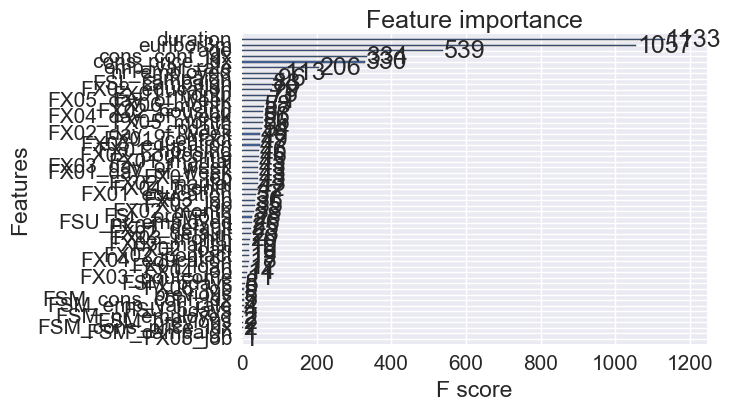

{'FSM_cons_conf_idx': 5, 'FX02_marital': 43, 'FX03_education': 47, 'FX01_job': 43, 'FX05_month': 56, 'FX02_job': 35, 'FX02_poutcome': 46, 'FSM_cons_price_idx': 2, 'FX01_contact': 49, 'FSL_previous': 28, 'cons_price_idx': 330, 'previous': 5, 'FX04_job': 14, 'nr_employed': 113, 'FSL_campaign': 83, 'FX02_default': 23, 'age': 539, 'FSM_pdays': 8, 'FX03_poutcome': 11, 'FX01_education': 37, 'FSU_nr_employed': 26, 'FX01_default': 25, 'FX02_day_of_week': 49, 'FSU_pdays': 4, 'euribor3m': 1057, 'pdays': 54, 'FX05_job': 1, 'FX01_day_of_week': 43, 'FX04_month': 42, 'FX02_contact': 19, 'FX03_day_of_week': 43, 'FSM_previous': 2, 'cons_conf_idx': 334, 'FX03_job': 36, 'FX02_loan': 19, 'FSM_emp_var_rate': 4, 'FX02_education': 79, 'FX01_month': 75, 'FX06_month': 58, 'FX03_month': 20, 'FX01_housing': 46, 'FX04_day_of_week': 56, 'FX02_month': 33, 'FX06_job': 5, 'FSM_campaign': 1, 'FX02_housing': 57, 'FX01_marital': 43, 'FX01_loan': 17, 'duration': 1133, 'FX04_education': 18, 'FX05_day_of_week': 71, 'campa

In [30]:
# import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(font_scale = 1.5)
xgb.plot_importance(optimized_GBM.best_estimator_)
plt.show()
#print(optimized_GBM.best_estimator_.feature_importances_)
# 获取重要变量
print(optimized_GBM.best_estimator_.get_booster().get_fscore())

### 4.2.3 使用最优参数重新训练模型

In [6]:
import xgboost as xgb
varsele_xgb_final_param = {'max_depth': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8
               ,'min_child_weight':100, 'objective': 'binary:logistic', 'n_estimators': 2000}
varsele_xgb_task_param = {'early_stopping_rounds': 50, 'seed':0,'verbose_eval':True, 'metrics':'auc'}
varsele_xgb_train = xgb.DMatrix(df_ppc_all_excat, label=y_train)

varsele_xgb_final_cv = xgb.cv(varsele_xgb_final_param, varsele_xgb_train, **varsele_xgb_task_param, num_boost_round=2000)


[0]	train-auc:0.850532+0.00673648	test-auc:0.84666+0.00899792
[1]	train-auc:0.870417+0.00783735	test-auc:0.864113+0.00302594
[2]	train-auc:0.887945+0.0141421	test-auc:0.883466+0.0152324
[3]	train-auc:0.903322+0.00402576	test-auc:0.902529+0.00350343
[4]	train-auc:0.910212+0.00281511	test-auc:0.907779+0.00025386
[5]	train-auc:0.914237+0.00313054	test-auc:0.911707+0.00302913
[6]	train-auc:0.916004+0.00494953	test-auc:0.91383+0.00468749
[7]	train-auc:0.918841+0.00590731	test-auc:0.915882+0.0047984
[8]	train-auc:0.92064+0.00446193	test-auc:0.918853+0.00266296
[9]	train-auc:0.921469+0.00326216	test-auc:0.920412+0.000525643
[10]	train-auc:0.922286+0.00385952	test-auc:0.920807+0.00143045
[11]	train-auc:0.924395+0.00130039	test-auc:0.923218+0.00249349
[12]	train-auc:0.924901+0.00114285	test-auc:0.923675+0.00269526
[13]	train-auc:0.923802+0.000909135	test-auc:0.922658+0.00330832
[14]	train-auc:0.924656+0.00194482	test-auc:0.923601+0.00319611
[15]	train-auc:0.9253+0.00121457	test-auc:0.923897+0.0

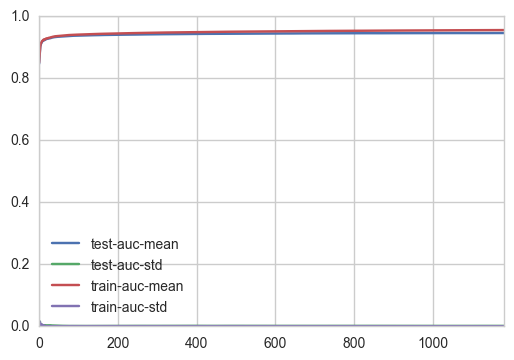

In [10]:
varsele_xgb_bst_inter = varsele_xgb_final_cv.shape[0]
varsele_xgb_final_cv.plot()
plt.show()

In [11]:
varsele_xgb_train_task_param=['num_boost_round','evals','obj','feval','maximize'
                              ,'evals_result','verbose_eval','xgb_model','callbacks','learning_rates']
varsele_xgb_task_param = {k:v for k,v in varsele_xgb_task_param.items() if k in varsele_xgb_train_task_param}
varsele_xgb_final_model = xgb.train(varsele_xgb_final_param, varsele_xgb_train, **varsele_xgb_task_param
                                 , num_boost_round = varsele_xgb_bst_inter, evals = [(varsele_xgb_train, 'train')])


[0]	train-error:0.096451
[1]	train-error:0.098879
[2]	train-error:0.100545
[3]	train-error:0.099712
[4]	train-error:0.098047
[5]	train-error:0.098081
[6]	train-error:0.099851
[7]	train-error:0.098012
[8]	train-error:0.098081
[9]	train-error:0.099781
[10]	train-error:0.098741
[11]	train-error:0.098741
[12]	train-error:0.098463
[13]	train-error:0.098498
[14]	train-error:0.098151
[15]	train-error:0.097457
[16]	train-error:0.095896
[17]	train-error:0.096312
[18]	train-error:0.095514
[19]	train-error:0.093918
[20]	train-error:0.095826
[21]	train-error:0.096867
[22]	train-error:0.096138
[23]	train-error:0.094751
[24]	train-error:0.094889
[25]	train-error:0.094959
[26]	train-error:0.09253
[27]	train-error:0.093189
[28]	train-error:0.092808
[29]	train-error:0.092322
[30]	train-error:0.092149
[31]	train-error:0.092322
[32]	train-error:0.092322
[33]	train-error:0.092218
[34]	train-error:0.092843
[35]	train-error:0.091732
[36]	train-error:0.091732
[37]	train-error:0.091975
[38]	train-error:0.0916

In [12]:
varsele_xgb = varsele_xgb_final_model.get_fscore()
varsele_xgb_df = pd.DataFrame([{'varname':k, 'xgb_imp':v} for k,v in varsele_xgb.items()])
varsele_xgb_df.head()

,varname,xgb_imp
0,FSM_emp_var_rate,3
1,FX04_day_of_week,27
2,FX01_marital,22
3,FX01_poutcome,8
4,FX01_default,22


#### 合并相关的重要变量

In [15]:
varsele_score_table = pd.merge(varsele_score_table, varsele_xgb_df, how = 'outer')
varsele_score_table.head()

,varname,iv,xgb_imp
0,age,0.174856,279.0
1,campaign,0.061652,75.0
2,cons_conf_idx,1.244232,209.0
3,cons_price_idx,0.626147,211.0
4,contact,0.267990,NaN


### 4.3 使用共线性筛选变量
#### 4.3.1 定义函数

In [6]:
def varsele_findcorrelation(corrMatrix, thresh=0.9):
    """
    Given a 2D numpy array, this will find highly correlated features,
    and return a list of features to remove(position of each variable)
    params:
    - df : numpy matrix
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    if corrMatrix.shape[0] != corrMatrix.shape[1]:
        raise Exception('corralation matrix should be square matrix')
    
    n = corrMatrix.shape[0]
    removeList = []
    
    for i in range(n - 1):
        colindex = np.where(np.abs(corrMatrix[:, i]) > thresh)[0]
        colindex = colindex[colindex > i]
        removeList = removeList + list(colindex)
    return list(set(removeList))
            

def varsele_findlinearcombos(mat, thresh = 1e-10):
    """
    Given a numpy matrix(row is record and column is feature), this will find collinear features,
    and return a list of features to remove(position of each variable)
    params:
    - df : numpy array
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    Q, R = np.linalg.qr(mat)
    removeList = np.where(np.abs(R.diagonal()) <= thresh)[0]
    return list(removeList)

In [26]:
# 移除相关性高的变量
varsele_corr_linear_remain = np.array(df_ppc_all_excat.columns)
res = varsele_findcorrelation(np.corrcoef(df_ppc_all_excat, rowvar=False))
varsele_corr_linear = set(varsele_corr_linear_remain[res])
varsele_corr_linear_remain = list(set(varsele_corr_linear_remain) - varsele_corr_linear)
# 移除贡献性变量
res = varsele_findlinearcombos(df_ppc_all_excat[varsele_corr_linear_remain])
varsele_corr_linear = varsele_corr_linear | set(np.array(varsele_corr_linear_remain)[res])

/Applications/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


In [33]:
# 生成评分表
varsele_corr_score = dict({}.fromkeys(df_ppc_all_excat.columns,0), **{}.fromkeys(varsele_corr_linear, 1))
varsele_corr_score = [{'varname':k, 'colinear':v} for k,v in varsele_corr_score.items()]
varsele_corr_score = pd.DataFrame(varsele_corr_score)
varsele_corr_score.head()

,colinear,varname
0,0,FSM_cons_price_idx
1,0,FX04_month
2,0,FX03_month
3,1,FX02_housing
4,0,FX08_job


##### 合并重要变量

In [34]:
varsele_score_table = pd.merge(varsele_score_table, varsele_corr_score, how = 'outer')
varsele_score_table.head()

,varname,iv,xgb_imp,colinear
0,age,0.174856,279.0,0.0
1,campaign,0.061652,75.0,0.0
2,cons_conf_idx,1.244232,209.0,0.0
3,cons_price_idx,0.626147,211.0,0.0
4,contact,0.267990,NaN,NaN


### 4.4输出重要变量评分矩阵

In [17]:
# load information value for numeric variable and categoric variable
# import pandas as pd
# vartrans_woe_num_table = pd.read_csv(parentpath + 'result/vartrans_woe_num_table.csv', sep = '\t')
# vartrans_woe_cat_table = pd.read_csv(parentpath + 'result/vartrans_woe_cat_table.csv', sep = '\t')
# vartrans_iv_commonvar = ['varname', 'iv']
# vartrans_iv_all= pd.concat([vartrans_woe_num_table[vartrans_iv_commonvar], vartrans_woe_cat_table[vartrans_iv_commonvar]])
# vartrans_iv_all.replace([np.inf, -np.inf], np.nan, inplace=True)
# varsele_score_table = vartrans_iv_all.groupby(['varname']).sum(skipna = True).reset_index()
varsele_score_table.to_csv(parentpath + 'result/varsele_score_table.csv', index=False, sep = '\t')


## 5. 变量变换

## 说明
变量变量指的是针对既有的输入变量做一些转换操作，使变量更能反映其与目标的关系。按常规来分：
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
1. 数值型变量变量：主要包含常规的power transformation，有$x^2$, $x^{1/2}$ , 1/x以及ln(x)
2. 类别型变量：特有的主要是one hot编码
3. 其他常规方法：针对类别变量做WOE变换；对连续性变量离散化，做onehot变换，以及WOE变换
4. 非常规的变换方法：
        a. 基于模型叶子的变换：将随机森里与gbdt决策路径当做特征；
        b. 基于spline的变换：通过模型得到二维变量与目标的关系，并通过spline拟合

这里只提供一些简单变换的示例。

### 5.0 load 变量选择的变量评分表

In [8]:
# load vairbale score table
import pandas as pd
varsele_score_table = pd.read_csv(parentpath + 'result/varsele_score_table.csv', sep = '\t')
df_ppc_all = pd.read_csv(parentpath + 'data/preproc_all.csv', sep = '\t')
df_ppc_all_excat = df_ppc_all[list(set(df_ppc_all.columns) - set(catvars))]
varsele_score_table.head()

,varname,iv,xgb_imp
0,age,0.174856,279.0
1,campaign,0.061652,75.0
2,cons_conf_idx,1.244232,209.0
3,cons_price_idx,0.626147,211.0
4,contact,0.267990,NaN


### 5.1 变量变换函数定义

In [1]:
import numpy as np
def vartrans_num_basic(dfinput):
    '''
    basic transformation for numeric variable
    Args:
            dfinput: input dataframe with selected variables
    returns:
            a dict with variable transformed
    
    '''
    result = {}
    for k, v in dfinput.items():
        result['SQ_%s' %k] = v**2
        result['SR_%s' %k] = np.sqrt(v)
        result['LG_%s' %k] = np.log10(v+1)
        result['IV_%s' %k] = 1/(v+1)
    return result

# 针对数值型变量，提取切割点，以及分组映射结果。数值变量直接映射
# 字典为二级结构，一级为变量，二级针对变量的映射
def vartrans_woe_gencode(eda_woe, vartype = 'n'):
    if vartype == 'n':
        dfmap = eda_woe.groupby(['varname']).apply(lambda x: list(zip(x['group'], x['woe']))).reset_index()
        dfmap.columns = ['varname', 'mapping']
        dfindice = eda_woe.groupby(['varname'])['upper'].apply(lambda x: list(x[:-1])).reset_index()
        dfindice.columns = ['varname', 'cut']
        dfWoe = pd.merge(dfmap, dfindice)
        res = dfWoe.set_index('varname').to_dict(orient='index')
    else:
        dfmap = eda_woe.groupby(['varname']).apply(lambda x: dict(zip(x['value'], x['woe']))).reset_index()
        dfmap.columns = ['varname', 'mapping']
        res = dfmap.set_index('varname').to_dict(orient='index')
    return res

# 单个变量的WOE变换，通过参数控制是针对数值型，或是类别型做变换
def vartrans_woe_single(arr, mapinfo, vartype = 'n'):
    if vartype == 'n':
        grpIdx = 0
        for cut in mapinfo['cut']:
            grpIdx = grpIdx + (arr > cut)
        mapvalue = np.array([e[1] for e in sorted(mapinfo['mapping'], key=lambda x: x[0])])
        res = mapvalue[grpIdx]
    else:
        elemarr, grpIdx = np.unique(arr, return_inverse=True)
        mapvalue = np.array([mapinfo['mapping'][e] for e in elemarr])
        res = mapvalue[grpIdx]
    return res

# WOE变换主函数，读入待变换数据，及变换规则，对所有相关数据变换
def vartrans_woe_main(X, vartrans_woe_num_mapping, vartrans_woe_cat_mapping):
    vars_woe_cat = set(X.keys()) & set(vartrans_woe_cat_mapping.keys())
    vars_woe_num = set(X.keys()) & set(vartrans_woe_num_mapping.keys())

    res = {}
    for k in vars_woe_cat:
        res['WOE_%s' %k] = vartrans_woe_single(X[k], vartrans_woe_cat_mapping[k], vartype = 'c')
    for k in vars_woe_num:
        res['WOE_%s' %k] = vartrans_woe_single(X[k], vartrans_woe_num_mapping[k], vartype = 'n')

    return res

# spline 变换部分
# splev源码
# https://github.com/scipy/scipy/blob/v1.0.0/scipy/interpolate/fitpack.py#L293-L368
# 构造样条函数并提取节点与系数
# https://stackoverflow.com/questions/41829515/getting-coefficients-of-a-cubic-spline-from-scipy-interpolate-splrep
# Bspline 与cubic spline 关系
# https://math.stackexchange.com/questions/699113/relation-of-cubic-b-splines-with-cubic-splines
import scipy.interpolate as itp
def vartrans_spl_single(x, y, knot):
    idx_x = np.argsort(x) 
    spl = splrep(x[idx_x], y[idx_x], t = knot, s = 0)
    return spl

def vartrans_spl_main(X, y, knots):
    spl_info = {}
    for k in knots.keys():
        spl = vartrans_spl_single(X[k], y, knots[k])
        spl_info[k] = {'knot':spl[0], 'coef':spl[1], 'degree':spl[2]}
        
    return spl_info

def vartrans_spl_eval_single(x, spl):
    return itp.splev(x, spl)

def vartrans_spl_eval_main(X, spl_info):
    res = {}
    for k, v in spl_info.items():
        res['SPL_%s' % k] = vartrans_spl_eval_single(X[k], (v['knot'], v['coef'], v['degree']))
        
    return res

In [9]:
import json
vartrans_woe_num_table = pd.read_csv(parentpath + 'result/vartrans_woe_num_table.csv', sep = '\t')
vartrans_woe_cat_table = pd.read_csv(parentpath + 'result/vartrans_woe_cat_table.csv', sep = '\t')

vartrans_woe_num_mapping = vartrans_woe_gencode(vartrans_woe_num_table)
vartrans_woe_cat_mapping = vartrans_woe_gencode(vartrans_woe_cat_table, vartype='c')

with open(parentpath + 'result/vartrans_woe_num_mapping.json','w') as f:
    f.write(json.dumps(vartrans_woe_num_mapping))

with open(parentpath + 'result/vartrans_woe_cat_mapping.json','w') as f:
    f.write(json.dumps(vartrans_woe_cat_mapping))

### 5.3 提取对应变量并做相应变换处理

In [6]:
varsele_from_varsele = list(varsele_score_table['varname'][varsele_score_table['xgb_imp'] > 30])

df_varsele_all = df_ppc_all_excat[varsele_from_varsele]
df_varsele_num = df_varsele_all[list(set(numvars) & set(varsele_from_varsele))]
df_vartrans_num_power = pd.DataFrame(vartrans_num_basic(df_varsele_num.to_dict('series')))

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


In [43]:
# woe变换
df_vartrans_num_woe = pd.DataFrame(
    vartrans_woe_main(df_ppc_all.to_dict('series'), vartrans_woe_num_mapping, vartrans_woe_cat_mapping))
df_vartrans_num_woe.head()

,WOE_age,WOE_campaign,WOE_cons_conf_idx,WOE_cons_price_idx,WOE_contact,WOE_day_of_week,WOE_default,WOE_duration,WOE_education,WOE_emp_var_rate,WOE_euribor3m,WOE_housing,WOE_job,WOE_loan,WOE_marital,WOE_month,WOE_nr_employed,WOE_pdays,WOE_poutcome,WOE_previous
0,-0.353403,0.159370,-0.867262,-0.221522,-0.317641,-0.079461,0.889371,-0.065081,0.306535,-0.835412,-0.827002,-0.054857,0.566269,-0.005213,0.118617,0.063597,-0.835412,0.0,0.280163,-0.280163
1,-0.180451,0.159370,-0.616413,-0.221522,-0.317641,0.035014,-0.157496,-0.901616,-0.303477,-0.583569,-0.724418,0.064006,0.016440,-0.005213,0.118617,0.109137,-0.586566,0.0,0.280163,-0.280163
2,0.225076,-0.051423,1.958781,0.376059,-0.317641,-0.079461,-0.157496,0.213117,-0.231215,0.720492,2.005392,-0.054857,-0.067291,-0.005213,-0.248056,0.093666,2.161813,0.0,-2.681983,1.076858
3,-0.353403,0.034135,0.910116,0.229047,-0.317641,0.035014,-0.157496,-0.485997,0.044391,0.720492,0.788972,0.064006,0.369191,-0.005213,0.118617,-0.739362,0.157652,0.0,0.280163,-0.280163
4,-0.180451,0.159370,1.766879,1.668847,-0.317641,0.035014,-0.157496,-0.901616,0.306535,1.612153,1.800874,-0.054857,-0.942673,-0.005213,0.118617,0.063597,1.612153,0.0,-2.681983,1.076858


### 5.4 合并变换后的数据

In [7]:
df_vartrans_all = pd.concat([df_varsele_all, df_vartrans_num_power], axis=1)
df_vartrans_all.columns

Index(['age', 'campaign', 'cons_conf_idx', 'cons_price_idx', 'duration',
       'emp_var_rate', 'euribor3m', 'nr_employed', 'FX01_contact',
       'FX05_day_of_week', 'FX02_poutcome', 'FX05_month', 'FX01_month',
       'FX06_month', 'FX02_education', 'IV_age', 'IV_campaign',
       'IV_cons_conf_idx', 'IV_cons_price_idx', 'IV_duration',
       'IV_emp_var_rate', 'IV_euribor3m', 'IV_nr_employed', 'LG_age',
       'LG_campaign', 'LG_cons_conf_idx', 'LG_cons_price_idx', 'LG_duration',
       'LG_emp_var_rate', 'LG_euribor3m', 'LG_nr_employed', 'SQ_age',
       'SQ_campaign', 'SQ_cons_conf_idx', 'SQ_cons_price_idx', 'SQ_duration',
       'SQ_emp_var_rate', 'SQ_euribor3m', 'SQ_nr_employed', 'SR_age',
       'SR_campaign', 'SR_cons_conf_idx', 'SR_cons_price_idx', 'SR_duration',
       'SR_emp_var_rate', 'SR_euribor3m', 'SR_nr_employed'],
      dtype='object')

### 5.5 移除部分变换出问题的变量
针对sqrt与log变换的变量，由于取值的问题，导致变量变换后会出现非法值。这种情况下，我们暂时把存在这种取值的变量去掉，后续考虑其他的处理方法。不过，从正常意义上讲，现实中碰到的变量一般是取正值的。

In [12]:
vars_vartrans_isillegal = df_vartrans_all.apply(lambda x: any(np.isnan(x)))
vars_vartrans_illegal = list(vars_vartrans_isillegal[vars_vartrans_isillegal].index)

vars_vartrans_illegal

['LG_cons_conf_idx', 'LG_emp_var_rate', 'SR_cons_conf_idx', 'SR_emp_var_rate']

In [16]:
df_vartrans_all = df_vartrans_all[list(set(df_vartrans_all.columns) - set(vars_vartrans_illegal))]

df_vartrans_all.to_csv(parentpath + 'data/vartrans_sele_all.csv', index=False, sep = '\t')

## 6 模型选择
此处我们主要使用使用最多的三个模型用于展示模型选择，主要包含：
1. 线性模型：逻辑回归
2. gbm：这里我们使用常用的xgboost
3. 随机森林

为了能够更好的与后续的模型评估相结合，这里我们把组合模型也置于此模块。

### 6.1 单模型方法

#### 6.1.0 加载数据

In [56]:
import pandas as pd
df_vartrans_sele_all = pd.read_csv(parentpath + 'data/vartrans_sele_all.csv', sep = '\t')

#### 6.1.1 函数定义
定制特定模型选择函数

In [48]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def varsele_get_pvalue(X, y, target_type = 'b'):
    """
    Given a independent variable matrix and target array, return t-test for each variable
    params:
    - X : input independent array
    - y : target variable
    - target_type: binary target or continous target
    
    """
    X = sm.add_constant(X)
    estimator = sm.GLM(y, X, family=sm.families.Binomial()) if target_type == 'b' else sm.OLS(y, X)
    model_stat = estimator.fit().summary()
    model_stat_data = model_stat.tables[1].data
    df = pd.DataFrame(data=model_stat_data[1:], columns=model_stat_data[0])
    
    return df

def modsele_stepwise_single(X, y, columns, varSelected, newVar, target_type = 'b', index = 'pvalue'):
    modelVars = varSelected + [newVar]
    varIdx = [columns.index(i) for i in modelVars]
    res = varsele_get_pvalue(X[:, varIdx], y, target_type = 'b')
    return np.array(res['P>|z|'], dtype=np.float64)[-1]
    
def modsele_stepwise_backward(X, y, columns, varSelected, target_type = 'b', index = 'pvalue'):
    
    varIdx = [columns.index(i) for i in varSelected]
    res = varsele_get_pvalue(X[:, varIdx], y, target_type = 'b')
    res['varname'] = ['intercept'] + varSelected
    
    return res


# stepwise
def modsele_stepwise(X, y, columns, target_type = 'b', step = 'forward', index = 'pvalue', pin = 0.001, pout = 0.005):
    varSelected = columns.copy() if step == 'backward' else []
    varPool = [] if step == 'backward' else columns.copy()
    idxForward = 0
    idxBackWard = 1
    while idxForward < pin:
        idxForward = 1
        idxBackWard = 1
        if step != 'backward':
            tempVarName = ''
            tempIdxForward = 1
            for var in varPool:
                tempIdx = modsele_stepwise_single(X, y, columns, varSelected, var, target_type, index)
                if tempIdx < tempIdxForward:
                    tempIdxForward = tempIdx
                    tempVarName = var
                #print("froward:", var, tempIdx, tempIdxForward)
            if tempIdxForward > pin:
                break
            varSelected.append(tempVarName)
            varPool.pop(varPool.index(tempVarName))
            idxForward = tempIdxForward
            
        if step != 'forward':
            while len(varSelected) > 0 and idxBackWard > pout:
                dfStat = modsele_stepwise_backward(X, y, columns, varSelected, target_type)
                idxBackWard = np.max(np.array(dfStat['P>|z|'], dtype=np.float64)[1:])
                if idxBackWard > pout:
                    varSelected.pop(np.argmax(np.array(dfStat['P>|z|'], dtype=np.float64)[1:]))
#             print('backward:', varSelected)
#             print('backward-varPool:', varPool)
    return varSelected


#### 6.1.2 逻辑回归

In [49]:
vars_modsele_stepwise = modsele_stepwise(np.array(df_vartrans_sele_all), y_train, list(df_vartrans_sele_all.columns)
                                         , target_type = 'b',step = 'stepwise', index = 'pvalue', pin = 0.001, pout = 0.005)
vars_modsele_stepwise

['LG_duration',
 'FX02_education',
 'FX01_month',
 'FX02_poutcome',
 'LG_nr_employed',
 'duration',
 'FX06_month',
 'SR_nr_employed',
 'euribor3m',
 'FX01_contact',
 'cons_conf_idx',
 'LG_euribor3m',
 'FX05_month']

In [53]:
estimator = sm.GLM(y_train, sm.add_constant(df_vartrans_sele_all[vars_modsele_stepwise]), family=sm.families.Binomial())
model_modsele_stepwise = estimator.fit().summary()
model_modsele_stepwise_data = model_modsele_stepwise.tables[1].data
model_modsele_stepwise_coef = pd.DataFrame(data=model_modsele_stepwise_data[1:], columns=model_modsele_stepwise_data[0])
print(model_modsele_stepwise_coef)

model_modsele_stepwise_coef.rename({'':'variable'}, inplace=True)
model_modsele_stepwise_coef.to_csv(parentpath + 'model/model_modsele_stepwise.csv', index=False, sep = '\t')

                          coef    std err          z   P>|z|     [0.025  \
0            const  -1.358e+05      1e+04    -13.570   0.000  -1.55e+05   
1      LG_duration      4.0212      0.228     17.658   0.000      3.575   
2   FX02_education      0.2406      0.052      4.649   0.000      0.139   
3       FX01_month     -2.2306      0.095    -23.500   0.000     -2.417   
4    FX02_poutcome     -0.7294      0.074     -9.807   0.000     -0.875   
5   LG_nr_employed   4.794e+04   3530.356     13.580   0.000    4.1e+04   
6         duration      0.0012      0.000      5.223   0.000      0.001   
7       FX06_month     -1.3212      0.105    -12.626   0.000     -1.526   
8   SR_nr_employed   -587.0302     43.118    -13.614   0.000   -671.541   
9        euribor3m      4.6372      0.427     10.865   0.000      3.801   
10    FX01_contact      0.4612      0.076      6.032   0.000      0.311   
11   cons_conf_idx     -0.0807      0.010     -8.263   0.000     -0.100   
12    LG_euribor3m    -30

#### 6.1.3 xgboost模型

##### grid search 超参数调整

In [54]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
cv_params = {'max_depth': [2,3,4], 'learning_rate': [0.1,0.01]}
ind_params = {'early_stopping_rounds': 50, 'n_estimators': 2000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'min_child_weight':100}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = -1) 
optimized_GBM.fit(df_vartrans_sele_all, y_train)

print(optimized_GBM.best_params_)
optimized_GBM.grid_scores_

/Applications/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'learning_rate': 0.1, 'max_depth': 2}


[mean: 0.94492, std: 0.00327, params: {'learning_rate': 0.1, 'max_depth': 2},
 mean: 0.94471, std: 0.00299, params: {'learning_rate': 0.1, 'max_depth': 3},
 mean: 0.94480, std: 0.00284, params: {'learning_rate': 0.1, 'max_depth': 4},
 mean: 0.93947, std: 0.00328, params: {'learning_rate': 0.01, 'max_depth': 2},
 mean: 0.94232, std: 0.00337, params: {'learning_rate': 0.01, 'max_depth': 3},
 mean: 0.94351, std: 0.00325, params: {'learning_rate': 0.01, 'max_depth': 4}]

##### cross validation 确定最佳树的数量

[0]	train-auc:0.850532+0.00673648	test-auc:0.84666+0.00899792
[1]	train-auc:0.86334+0.00329797	test-auc:0.860915+0.00100755
[2]	train-auc:0.863322+0.00246872	test-auc:0.861098+0.00124247
[3]	train-auc:0.864307+0.0027181	test-auc:0.861702+0.00132702
[4]	train-auc:0.876394+0.00405435	test-auc:0.874981+0.00158632
[5]	train-auc:0.879581+0.00591531	test-auc:0.877764+0.00445725
[6]	train-auc:0.882706+0.00758805	test-auc:0.880574+0.00407912
[7]	train-auc:0.885831+0.0040997	test-auc:0.88384+0.00149656
[8]	train-auc:0.886122+0.00385242	test-auc:0.884335+0.00135831
[9]	train-auc:0.886626+0.00400627	test-auc:0.884706+0.000924441
[10]	train-auc:0.892265+0.00809016	test-auc:0.890375+0.00347342
[11]	train-auc:0.905185+0.00845649	test-auc:0.902562+0.00860533
[12]	train-auc:0.913449+0.00703759	test-auc:0.910221+0.011903
[13]	train-auc:0.919564+0.00230753	test-auc:0.918268+0.00144391
[14]	train-auc:0.921405+0.00201142	test-auc:0.919874+0.00315897
[15]	train-auc:0.923134+0.00107041	test-auc:0.921398+0.0

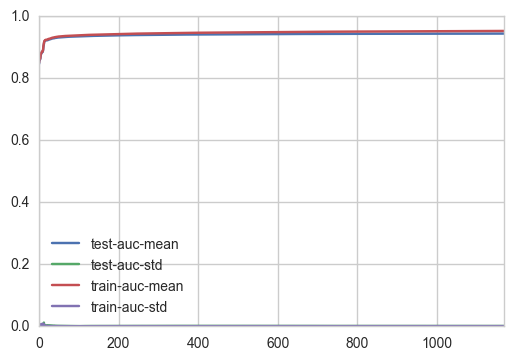

In [57]:
# 需要整理xgb.cv GridSearchCV 以及xgb.train中参数映射关系
modsele_xgb_model_param = {'max_depth': 2, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8
               ,'min_child_weight':100, 'objective': 'binary:logistic', 'n_estimators': 2000}
modsele_xgb_task_param = {'early_stopping_rounds': 50, 'seed':0,'verbose_eval':True, 'metrics':'auc'}
modsele_xgb_train = xgb.DMatrix(df_vartrans_sele_all, label=y_train)

modsele_xgb_final_cv = xgb.cv(modsele_xgb_model_param, modsele_xgb_train, **modsele_xgb_task_param, num_boost_round=4000)

modsele_xgb_bst_inter = modsele_xgb_final_cv.shape[0]
modsele_xgb_final_cv.plot()
plt.show()

##### 使用最佳的树的个数训练最终模型

In [58]:
modsele_xgb_train_task_param=['num_boost_round','evals','obj','feval','maximize'
                              ,'evals_result','verbose_eval','xgb_model','callbacks','learning_rates']
modsele_xgb_task_param = {k:v for k,v in modsele_xgb_task_param.items() if k in modsele_xgb_train_task_param}
model_modsele_xgb = xgb.train(modsele_xgb_model_param, modsele_xgb_train, **modsele_xgb_task_param
                                 , num_boost_round = modsele_xgb_bst_inter, evals = [(modsele_xgb_train, 'train')])


[0]	train-error:0.096277
[1]	train-error:0.094716
[2]	train-error:0.094716
[3]	train-error:0.096277
[4]	train-error:0.094716
[5]	train-error:0.092669
[6]	train-error:0.092669
[7]	train-error:0.092669
[8]	train-error:0.092669
[9]	train-error:0.092669
[10]	train-error:0.092669
[11]	train-error:0.092669
[12]	train-error:0.092496
[13]	train-error:0.09423
[14]	train-error:0.094681
[15]	train-error:0.092461
[16]	train-error:0.094612
[17]	train-error:0.094612
[18]	train-error:0.094612
[19]	train-error:0.093294
[20]	train-error:0.093189
[21]	train-error:0.093294
[22]	train-error:0.093294
[23]	train-error:0.093189
[24]	train-error:0.093189
[25]	train-error:0.093189
[26]	train-error:0.092183
[27]	train-error:0.092287
[28]	train-error:0.093294
[29]	train-error:0.092391
[30]	train-error:0.092843
[31]	train-error:0.09194
[32]	train-error:0.092808
[33]	train-error:0.092808
[34]	train-error:0.092079
[35]	train-error:0.092218
[36]	train-error:0.09201
[37]	train-error:0.091906
[38]	train-error:0.09201


In [67]:
# save model
import json
model_modsele_xgb.save_model(parentpath + 'model/model_modsele_xgb')
# model_modsele_xgb.dump_model(parentpath + 'model/model_modsele_xgb_raw.txt',parentpath + 'model/model_modsele_xgb_featmap.txt')
# save feature name

with open(parentpath + 'model/model_modsele_xgb_feature.json', 'w+') as f:
    f.write(json.dumps(model_modsele_xgb.feature_names))

### 6.1.4 随机森林模型

#### 使用grid search 确定最有参数

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
# Build a classification task using 3 informative features

modsele_rf_grid_param = { 
    'n_estimators': [500, 1000],
    "criterion": ["gini", "entropy"],
    'min_samples_leaf':[50, 100],
    "max_depth" : [2,3,4]
}
modsele_rf_grid_est = RandomForestClassifier(n_jobs=-1, oob_score = True, random_state = 1) 

modsele_rf_grid_cv = GridSearchCV(estimator=modsele_rf_grid_est, param_grid=modsele_rf_grid_param, cv= 5, scoring = 'roc_auc')
modsele_rf_grid_cv.fit(df_vartrans_sele_all, y_train)

print(modsele_rf_grid_cv.best_params_)
modsele_rf_grid_cv.grid_scores_

{'max_depth': 4, 'n_estimators': 1000, 'min_samples_leaf': 50, 'criterion': 'entropy'}


[mean: 0.91411, std: 0.00293, params: {'max_depth': 2, 'n_estimators': 500, 'min_samples_leaf': 50, 'criterion': 'gini'},
 mean: 0.91679, std: 0.00233, params: {'max_depth': 2, 'n_estimators': 1000, 'min_samples_leaf': 50, 'criterion': 'gini'},
 mean: 0.91790, std: 0.00129, params: {'max_depth': 2, 'n_estimators': 500, 'min_samples_leaf': 100, 'criterion': 'gini'},
 mean: 0.91534, std: 0.00296, params: {'max_depth': 2, 'n_estimators': 1000, 'min_samples_leaf': 100, 'criterion': 'gini'},
 mean: 0.92623, std: 0.00414, params: {'max_depth': 3, 'n_estimators': 500, 'min_samples_leaf': 50, 'criterion': 'gini'},
 mean: 0.92692, std: 0.00322, params: {'max_depth': 3, 'n_estimators': 1000, 'min_samples_leaf': 50, 'criterion': 'gini'},
 mean: 0.92629, std: 0.00262, params: {'max_depth': 3, 'n_estimators': 500, 'min_samples_leaf': 100, 'criterion': 'gini'},
 mean: 0.92665, std: 0.00310, params: {'max_depth': 3, 'n_estimators': 1000, 'min_samples_leaf': 100, 'criterion': 'gini'},
 mean: 0.93269, 

#### 使用最佳参数重新训练模型

In [67]:
model_modsele_rf = RandomForestClassifier(**modsele_rf_grid_cv.best_params_)
model_modsele_rf.fit(df_vartrans_sele_all, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### 保存训练的模型
```python
# cPickle changed to _pickle, you can just import without any package installation
import cPickle

rf = RandomForestRegresor()
rf.fit(X, y)

with open('path/to/file', 'wb') as f:
    cPickle.dump(rf, f)

# in your prediction file                                                                                      
with open('path/to/file', 'rb') as f:
    rf = cPickle.load(f)

preds = rf.predict(new_X)
```

In [71]:
import _pickle as cPickle
with open(parentpath + 'model/model_modsele_rf', 'wb') as f:
    cPickle.dump(model_modsele_rf, f)

### 6.1.5 bootstrap混合模型
这一部分使用bagging的方法训练多组广义线性模型，把L1/L2等模型全部涵盖在这个部分。暂不考虑elasticnet，因为Python的实现存在一些问题

#### 定义基础函数
接受一组参数，以及对应的估计子，最终输出多个模型及参数  
```python
sklearn.linear_model.LogisticRegression(penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, verbose=0, warm_start=False, n_jobs=1)
```
特有参数：penalty, C, class_weight, solver, multi_class
```python
sklearn.linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')  
```
特有参数：alpha, l1_ratio, selection

common parameter：fit_intercept, tol, random_state, max_iter, n_jobs, verbose, warm_start
将penalty, C转换成alpha, l1_ratio，用于兼容后续的elasticnet

In [61]:
from sklearn import linear_model
def modsele_bs_func_get_est(target_type = 'b', **params):
    '''
    given certain parameter, return estimator
    Args:
            target_type: 'b' or 'c' for classification and continuous variable respectively
            params: param for define estimator
                alpha: required, Constant that multiplies the penalty terms
                l1_ratio : The ElasticNet mixing parameter
    returns:
            a dict with variable transformed
    
    '''
    common_params = ['fit_intercept', 'tol', 'random_state', 'max_iter', 'verbose', 'warm_start', 'n_jobs']
    param_dict = {}
    if target_type == 'b':
        param_dict['C'] = 1/params['alpha'] if params['alpha'] != 0 else 1e6
        param_dict['penalty'] = 'l1' if params['alpha'] != 0 and params.get('l1_ratio') == 1 else 'l2'
        if params.get('class_weight') is not None:
            param_dict['class_weight'] = params.get('class_weight')
        if params.get('multi_class') is not None:
            param_dict['multi_class'] = params.get('multi_class')
    else:
        param_dict['alpha'] = params.get('alpha')
        if params.get('l1_ratio') is not None:
            param_dict['l1_ratio'] = params.get('l1_ratio')
        if params.get('selection') is not None:
            param_dict['selection'] = params.get('selection')
    commonparamdict = {k:v for k, v in params.items() if k in common_params}
    
    param_dict = dict(param_dict, **commonparamdict)
    est = linear_model.LogisticRegression(**param_dict) if target_type == 'b' else linear_model.ElasticNet(**param_dict)
    return est

def modsele_bs_func_main(X, y, columns, n_rounds,target_type = 'b', eval_ds = None, scoring = 'roc_auc', seed = 0
                         , **params):
    '''
    training some models by boostrap from origin dataset
    Args:
            X: independent dataset
            y: dependent variable
            columns: variable name
            n_rounds: models to train or round to bootstrap
    returns:
            trained model with all coefficient, and evaluated result for this training
    '''
    est = modsele_bs_func_get_est(target_type, **params)
    
    X = np.array(X)
    n_sample = X.shape[0]
    np.random.seed(seed)
    df_coef = pd.DataFrame([])
    for i in range(n_rounds):
        # inplace sampling in each round
        idx_sample = np.random.choice(range(n_sample), n_sample)
        X_each_round = X[idx_sample,:]
        
        est.fit(X_each_round, y)
        
        # model evaluation, will be complete next
        eval_rnd = None
        
        # extract coefficient
        coef_rnd = est.coef_
        intercept = est.intercept_
        
        if len(coef_rnd.shape) == 1:
            coef_rnd = coef_rnd.reshape([-1, len(columns)])
        df_coef_rnd = pd.DataFrame(coef_rnd, columns=columns)
        df_coef_rnd['intercept'] = intercept
        df_coef_rnd['round'] = i
        
        df_coef = pd.concat([df_coef, df_coef_rnd])
    return df_coef, eval_rnd
    

In [70]:
model_modsele_bs, _ = modsele_bs_func_main(df_vartrans_sele_all, y_train, df_vartrans_sele_all.columns,10,
                                 'b',alpha=1.0, l1_ratio=0.5, fit_intercept=True, copy_X=True, tol=0.0001, random_state=1)


In [71]:
model_modsele_bs.to_csv(parentpath + 'model/model_modsele_bs.csv', sep = '\t')

## 7. 模型诊断与评估
基于已训练出的模型对测试数据集进行打分，并评估模型性能以及各个变量重要性

### 7.0 数据加载以及预处理
将测试数据集过一遍数据预处理以及变量变换的过程，并在后续应用到模型打分中

In [35]:
# load train data
df_vartrans_sele_all = pd.read_csv(parentpath + 'data/vartrans_sele_all.csv', sep = '\t')
# load label of test data
y_test = np.array(dstest[target])

# data preprocess
import result.func_preproc_num as fppcn
import result.func_preproc_cat as fppcc
# preprocess for numeric variable
# num_dict = {k: np.array(dstest[k], dtype = np.float64) for k in numvars}
ds_test_ppc_num = fppcn.dataproc_func_num({k: np.array(dstest[k], dtype = np.float64) for k in numvars})
# cat_dict = {k: np.array(df[k]) for k in catvars}
ds_test_ppc_cat = fppcc.dataproc_func_cat({k: np.array(dstest[k]) for k in catvars})

# variable transformation
ds_test_vartrans_num_power = vartrans_num_basic(ds_test_ppc_num)

ds_test_treat_all = pd.DataFrame(dict(ds_test_ppc_num, **ds_test_ppc_cat, **ds_test_vartrans_num_power))
ds_test_treat_all.head()

/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


,FM1_age,FM1_campaign,FM1_cons_conf_idx,FM1_cons_price_idx,FM1_duration,FM1_emp_var_rate,FM1_euribor3m,FM1_nr_employed,FM1_pdays,FM1_previous,...,age,campaign,cons_conf_idx,cons_price_idx,duration,emp_var_rate,euribor3m,nr_employed,pdays,previous
0,0,0,0,0,0,0,0,0,0,0,...,36.0,1.0,-40.8,92.963,174.0,-2.9,1.266,5076.2,3.0,1.0
1,0,0,0,0,0,0,0,0,0,0,...,27.0,2.0,-47.1,93.075,191.0,-1.8,1.410,5099.1,999.0,1.0
2,0,0,0,0,0,0,0,0,0,0,...,55.0,3.0,-36.1,93.444,372.0,1.4,4.965,5228.1,999.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,33.0,5.0,-46.2,92.893,75.0,-1.8,1.291,5099.1,999.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,28.0,1.0,-36.4,93.994,140.0,1.1,4.860,5191.0,999.0,0.0


### 7.1 加载模型并预测评估
分别load 原先训练好的模型，分别为：
1. 逻辑回归
2. gbdt
3. 随机森林
4. bootstrap融合模型

在此基础上，评估模型指标，以及评估各个变量重要性。

#### 7.1.0 定义函数
定义用于评估模型性能的基础公用函数

(array([1, 0, 1, ..., 0, 0, 0]),
 array([3.9915714e-01, 6.4261951e-02, 2.6758337e-02, ..., 6.8775320e-04,
        3.5402132e-04, 6.2665896e-04], dtype=float32))

#### 7.1.1 逻辑回归模型评估
##### 加载数据

In [20]:
# load model file
import pandas as pd
model_modsele_stepwise = pd.read_csv(parentpath + 'model/model_modsele_stepwise.csv', sep = '\t')
# model_modsele_stepwise.rename({'':'varname'}, inplace=True)
model_modsele_stepwise.head()
# model_modsele_stepwise.dtypes

,varname,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-135800.0000,10000.000,-13.570,0.0,-155000.000,-116000.000
1,LG_duration,4.0212,0.228,17.658,0.0,3.575,4.468
2,FX02_education,0.2406,0.052,4.649,0.0,0.139,0.342
3,FX01_month,-2.2306,0.095,-23.500,0.0,-2.417,-2.045
4,FX02_poutcome,-0.7294,0.074,-9.807,0.0,-0.875,-0.584


In [47]:
# define predict function
# will be complete in the next

In [41]:
import scipy
vars_moddiag_linear = list(model_modsele_stepwise['varname'])
ds_test_moddiag_linear = np.array(ds_test_treat_all[vars_moddiag_linear[1:]])
ds_test_moddiag_linear = np.append(ds_test_moddiag_linear, np.ones([len(ds_test_moddiag_linear), 1]), 1)
coef_moddiag_linear = np.array(model_modsele_stepwise['coef'])
coef_moddiag_linear = np.append(coef_moddiag_linear[1:], coef_moddiag_linear[0])
coef_moddiag_linear = coef_moddiag_linear.reshape([len(coef_moddiag_linear), 1])

In [45]:
logodd_test = -np.matmul(ds_test_moddiag_linear, coef_moddiag_linear)
pred_test = scipy.special.expit(logodd_test)

#### 7.1.2 xgboost模型评估
加载模型

In [6]:
import xgboost as xgb
import json
model_modsele_xgb = xgb.Booster()  # init model
model_modsele_xgb.load_model(parentpath + 'model/model_modsele_xgb')
with open(parentpath + 'model/model_modsele_xgb_feature.json', 'r') as f:
    model_modsele_xgb_feature = json.load(f)
# model_modsele_xgb.feature_names = model_modsele_xgb_feature

pred_test = model_modsele_xgb.predict(xgb.DMatrix(ds_test_treat_all[model_modsele_xgb_feature]))
pred_train = model_modsele_xgb.predict(xgb.DMatrix(df_vartrans_sele_all))

#### 7.1.3 bootstrap模型加载与预测
定义函数

In [52]:
# intercept置于最后第一位
import scipy
import numpy as np
def model_modsele_bs_predict(X, model):
    X = np.pad(X, ((0, 0), (1, 0)), 'constant', constant_values = 1)
    pred_logit = np.matmul(X, model.T)
    return scipy.special.expit(pred_logit)

In [55]:
import numpy as np
model_modsele_bs = pd.read_csv(parentpath + 'model/model_modsele_bs.csv', sep = '\t')
model_modsele_bs_var = list(set(model_modsele_bs.columns) - {'round', 'intercept'})
# intercept np.pad(X, ((0, 0), (1, 0)), 'constant', constant_values = 1)
pred_train_mm = model_modsele_bs_predict(np.array(df_vartrans_sele_all[model_modsele_bs_var]),
                                        np.array(model_modsele_bs[model_modsele_bs_var + ['intercept']]))
pred_test_mm = model_modsele_bs_predict(np.array(ds_test_treat_all[model_modsele_bs_var]),
                                        np.array(model_modsele_bs[model_modsele_bs_var + ['intercept']]))

pred_train = np.mean(pred_train_mm, axis=1)
pred_test = np.mean(pred_test_mm, axis=1)

## 7.2 模型评估

#### 7.2.1 函数定义
<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=default"></script>
定义用于画图，以及计算统计指标的函数。相关指标定义参见：
1. [Somers' D](https://en.wikipedia.org/wiki/Somers%27_D),   $AUC = \frac{D_{YX} + 1}{2}$
2. [ROC/AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
3. [KS](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)
4. [GINI](https://staesthetic.wordpress.com/2014/04/14/gini-roc-auc-and-accuracy/)

In [73]:
import numpy as np
import matplotlib.pyplot as plt
def modeval_stat_index_bin(pred, y):
    '''
    need to add Somer’s D
    '''
    idx_sorted = np.argsort(pred)
    y_sorted = y[idx_sorted]
    pred_sorted = pred[idx_sorted]
    cdf_pos = np.cumsum(y_sorted)/sum(y_sorted)
    cdf_neg = np.cumsum(1-y_sorted)/sum(1-y_sorted)
    KS = max(np.abs(cdf_pos - cdf_neg))
    
    integ_slice_X = cdf_neg[1:] - cdf_neg[:-1]
    integ_slice_Y = 1 - (cdf_pos[1:] + cdf_pos[:-1])/2
    AUC = sum(integ_slice_X * integ_slice_Y)
    GINI = 2*AUC - 1
    return KS, AUC, GINI

def modeval_plot_KS(pred, y, plt):
    idx_sorted = np.argsort(pred)
    y_sorted = y[idx_sorted]
    pred_sorted = pred[idx_sorted]
    cdf_pos = np.cumsum(y_sorted)/sum(y_sorted)
    cdf_neg = np.cumsum(1-y_sorted)/sum(1-y_sorted)
    cdf_all = np.linspace(1/len(y_sorted), 1, len(y_sorted))
    
    plt.plot(cdf_all,cdf_pos)
    plt.plot(cdf_all,cdf_neg)
    plt.legend(['positive', 'negative'], loc='upper left')
    
def modeval_plot_ROC(pred, y, plt):
    idx_sorted = np.argsort(pred)
    y_sorted = y[idx_sorted]
    pred_sorted = pred[idx_sorted]
    cdf_pos = np.cumsum(y_sorted)/sum(y_sorted)
    cdf_neg = np.cumsum(1-y_sorted)/sum(1-y_sorted)
    
    plt.plot(cdf_neg,1-cdf_pos)
    plt.legend(['ROC'], loc='upper left')
    

def modeval_plot_Lift(pred, y, plt):
    idx_sorted = np.argsort(pred)[::-1]
    y_sorted = y[idx_sorted]
    pred_sorted = pred[idx_sorted]

    y_mean = np.mean(y_sorted)
    pred_mean = np.mean(pred_sorted)
    groups = np.floor((np.array(range(len(idx_sorted)))/(len(idx_sorted)+1))*10)
    df = pd.DataFrame({'groups':groups, 'predict':pred_sorted, 'real':y_sorted})
    df4Plot = df.groupby(['groups'], as_index=False).mean()

    df4Plot['Pred. Index'] = np.floor(df4Plot['predict']/pred_mean *100)
    df4Plot['Real Index'] = np.floor(df4Plot['real']/pred_mean *100)

    df4Plot[['Pred. Index', 'Real Index']].plot(kind='bar')
    plt.title('Lift Chart')
    plt.xlabel('Groups')
    plt.ylabel('Lift Index')

#### 作图并计算统计量
##### 计算KS及AUC

In [14]:
modeval_stat_index_bin(pred_test, y_test), modeval_stat_index_bin(pred_train, y_train)

((0.7855788531660625, 0.9472486492835469, 0.8944972985670938),
 (0.7883534343644731, 0.9524094674452268, 0.9048189348904536))

##### KS作图

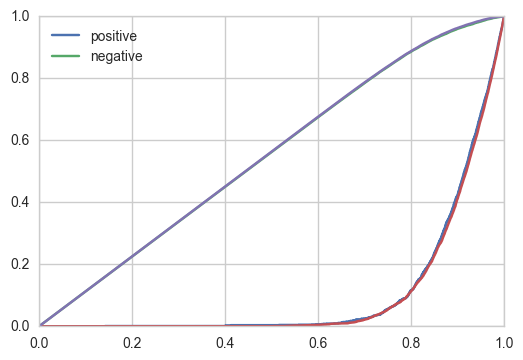

In [12]:
modeval_plot_KS(pred_test, y_test, plt)
modeval_plot_KS(pred_train, y_train, plt)
plt.show()

##### ROC 作图

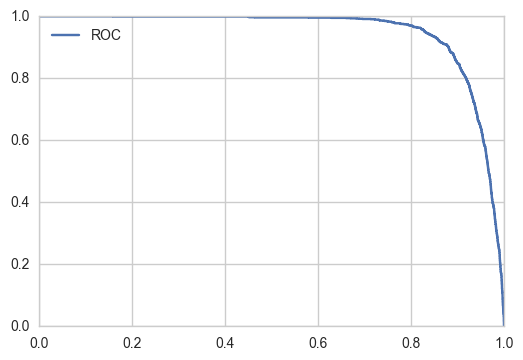

In [123]:
modeval_plot_ROC(pred_test, y_test, plt)
plt.show()

##### Lift Chart

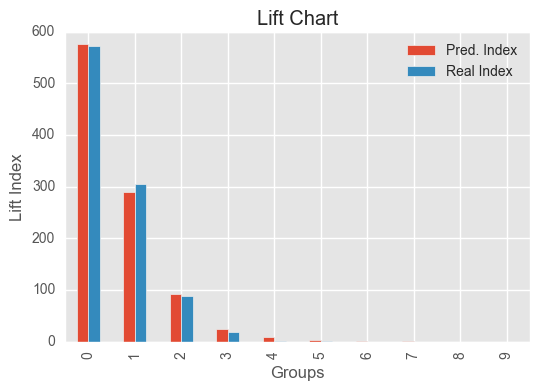

In [74]:
modeval_plot_Lift(pred_test, y_test, plt)
plt.show()

In [129]:
(np.array(range(len(idx_sorted)))/(len(idx_sorted)+1))*10

array([0.00000000e+00, 8.08668931e-04, 1.61733786e-03, ...,
       9.99676532e+00, 9.99757399e+00, 9.99838266e+00])

### 7.3 模型诊断
分为以下四个部分内容：  
    a)	outlier检测（cook's D）  
    b)	residual检测  
    c)  score distribution  
    d)	interaction 检测  

#### 7.3.1 函数定义

In [13]:
import numpy as np
def moddiag_plot_residual(pred, y, plt):
    residual = (y - pred)/np.sqrt(pred*(1 - pred))
    plt.scatter(pred, residual)
    plt.title("Pearson Residual")
    plt.xlabel('Predict')
    plt.ylabel("Distance")

def moddiag_cooksd_bin_appr(X, y, pred):
    # calculate W diagonal matrix with pred_i*(1 - pred_i) as element
    W = pred*(1 - pred)
    
    # Pearson Residual
    residp = (y - pred)/np.sqrt(W)
    # Deviance Residuals
    # residdev = np.sign(y - pred)*np.sqrt(-2*(y*np.log(pred) + (1 - y)*np.log(1 - pred)))
    # add constant to independent variable matrix as the first column
    X = np.pad(X, ((0, 0), (1, 0)), 'constant', constant_values = 1)
    
    # calculate hat value and extract the diagonal value
    hat = W * np.diag(np.matmul(X,
                                np.matmul(np.linalg.inv(np.matmul(X.T * W , X)), X.T)
                               ))
    # get number of variables(constant is included)
    p = X.shape[1]
    
    cooksd = residp**2 *hat/((1-hat)**2*p)
    
    return cooksd
    
def moddiag_plot_cooksd_bin_appr(X, y, pred, plt, style = 'k.'):
    cooksd = moddiag_cooksd_bin_appr(X, y, pred)
    plt.plot(cooksd, style)
    # plt.legend(['positive', 'negative'], loc='upper left')
    plt.title("Cook's D")
    plt.xlabel('Index')
    plt.ylabel("Cook's D")
    
def modiag_plot_score_dist(pred, classes, plt,target_type = 'b', style = 'line'):
    from scipy.stats import gaussian_kde
    if target_type == 'b':
        pred = [np.log(predi/(1-predi)) for predi in pred]
    for predi in pred:
        if style == 'line':
            dt_gauss_kde = gaussian_kde(predi)
            xplot = np.linspace(min(predi), max(predi), 1000)
            plt.plot( xplot, dt_gauss_kde(xplot))
        else:
            plt.hist(predi, 100, normed=True)
    
    plt.legend(classes, loc='upper left')
    plt.title("Score Distribution")
    plt.xlabel('Score')
    plt.ylabel("PDF")
    


#### 7.3.2 outlier检测

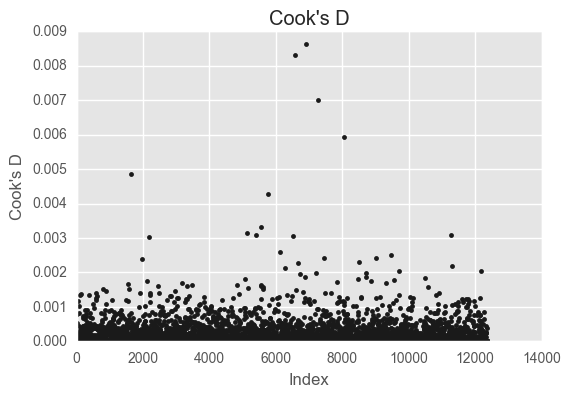

In [71]:
X_test = np.array(ds_test_treat_all[model_modsele_xgb_feature])
moddiag_plot_cooksd_bin_appr(X_test, y_test, pred_test, plt)
plt.show()

#### 7.3.3 residual plot

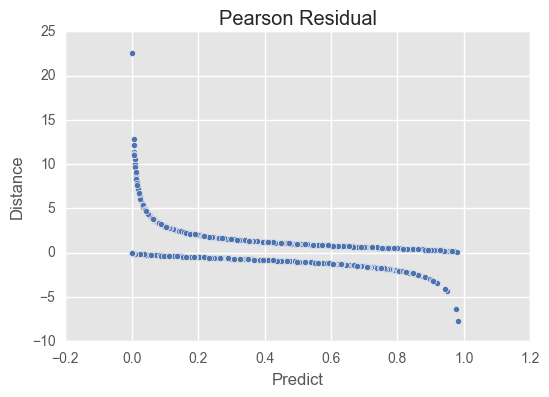

In [70]:
moddiag_plot_residual(pred_train, y_train, plt)
plt.show()

#### 7.3.4 预测分数分布

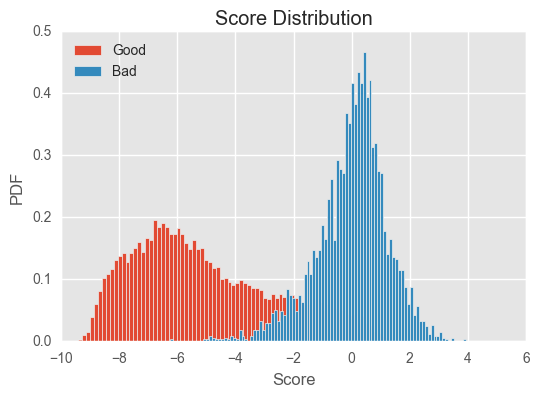

In [69]:
modiag_plot_score_dist([pred_train[y_train == 0],pred_train[y_train == 1]], classes = ['Good', 'Bad'], plt = plt,style = 'bar')
plt.show()

#### 7.3.5 interaction检测

### 7.4 模型解释
用来解释模型在业务上的意义，分为三个方面：
1. 模型级别的变量重要性  
3. 单变量与目标预测的关系
2. 观测级别的变量重要性

#### 7.4.0 函数定义

In [64]:
import numpy as np
def modexpl_plot_varimp(imp, plt, modtype = 'glm', **param):
    '''
    plot variable importance of given model
    Args:
            imp: variable importance
            plt: plot object
            modtype: model type which will be used as routing
            param: other parameter for some certain variable
    returns:
            variable importance
    '''
    pass

def modexpl_plot_bivar(X, y, pred, plt, varname = 'X', cutpoint = 10, vartype = 'c'):
        
    df_bivar = pd.DataFrame({'Real':y, 'Predict':pred})
    if vartype == 'c':
        if type(cutpoint) == type(10):
            df_bivar[varname] = pd.cut(X, cutpoint)
        else:
            df_bivar[varname] = pd.cut(X, [-np.inf] + list(cutpoint) + [np.inf])
    else:
        df_bivar[varname] = X
    df_bivar.groupby([varname]).mean().plot(kind='bar', rot=45)
    plt.title('Bivariate of {} and Target with Real and Predict Value'.format(varname))
    #plt.xlabel('Job')
    plt.ylabel('Mean of Target')

#### 7.4.1 模型变量重要性

#### 7.4.2 单变量与目标预测关系

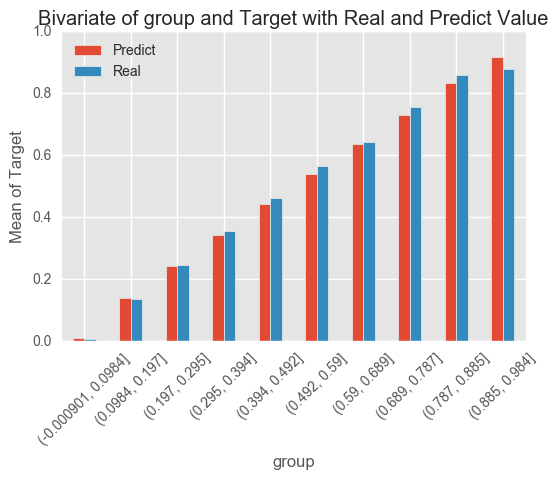

In [67]:
modexpl_plot_bivar(pred_train, y_train, pred_train, plt, 'group') # equal interval
plt.show()

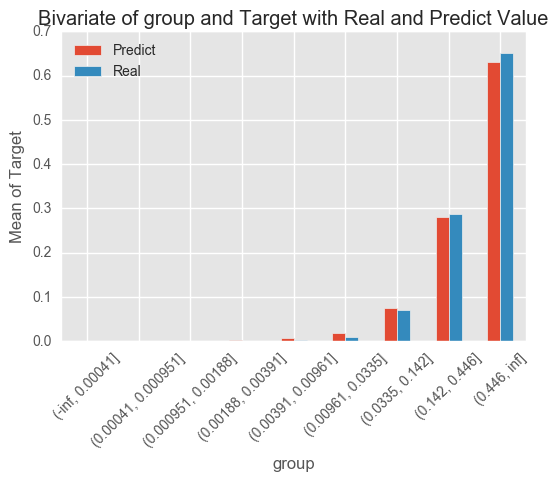

In [68]:
cutpoint = np.unique(np.percentile(pred_train, np.linspace(0, 100, 10)[1:-1])) # even decile
modexpl_plot_bivar(pred_train, y_train, pred_train, plt, 'group', cutpoint = cutpoint)
plt.show()

#### 7.4.3 观测级别变量重要性